In [259]:
import pandas as pd
import os
from cuml import TSNE, UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE as sklearn_tsne
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
home = '/home/tpjoe/tpjoe@stanford.edu/project_exosome/'

In [2]:
# load data
file_list = [i for i in os.listdir(os.path.join(home, 'data')) if '001_TotalParticles-All-All-A-BetaCD47PrPIM-AllParticles_particles' in i]
data_dict = {str(i)+'_'+str(k):v for i,d in enumerate([pd.read_excel(home+'data/'+filename, sheet_name=None, header=None) for filename in file_list]) for k,v in d.items()}
data_dict = {i:data_dict[i] for i in data_dict.keys() if all([j not in i for j in ['Parameters', 'Subpopulations', 'Pooled Control']])}

In [30]:
# load groundtruth
gt = pd.read_excel(os.path.join(home,'data','TPAD_CSF EV samples_koya.xlsx'))
gt = gt.loc[:, ['TPAD ID', 'Linkcode', 'Cohort', 'Diagnosis', 'PID 1-90']]
gt['PID 1-90'] = gt['PID 1-90'].astype('str')
gt.head(3)

,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
0,TPAD0473,141236,Poston,HC,1
1,TPAD0450,141091,Poston,HC,2
2,TPAD0494,141370,Poston,HC,3


In [24]:
# join data into a dataframe
data_list = []

for person in data_dict.keys():
    data_sample = [data_dict[person].iloc[:, i*5:(i*5+5)].transpose().reset_index(drop=True).transpose() for i in range(int(data_dict[person].shape[1]/5))]
    data_sample = [d.iloc[1:, :] for d in data_sample]
    data_sample = [d[~d.isna().all(axis=1)] for d in data_sample]

    for i in range(len(data_sample)):
        data_sample[i].loc[:,5] = data_sample[i].iloc[0,1]
        data_sample[i].loc[:,0] = data_sample[i].loc[:,0].fillna(method="ffill")
        data_sample[i].columns = ['spot'] + data_sample[i].iloc[1,1:5].tolist() + ['marker']
        data_sample[i] = data_sample[i].iloc[2:,:]

    data_df = pd.concat(data_sample, axis=0)
    data_exo = data_df.loc[(data_df.IM>=50) & (data_df.IM<=200), :].reset_index(drop=True)
    data_exo.loc[:, 'samples'] = person
    data_list += [data_exo]

df = pd.concat(data_list, axis=0).reset_index(drop=True)
df[['batch', 'samples']] = df.samples.str.split('_', expand=True)

In [31]:
# merge with gt
df = df.merge(gt, left_on='samples', right_on='PID 1-90', how='left')

In [136]:
df[['A-Beta','CD47','PrP','IM']] = df.loc[:, ['A-Beta','CD47','PrP','IM']].astype('float')

In [161]:
df_sub = pd.concat([df.loc[df.batch==i].sample(n=5000, random_state=1) for i in df.batch.unique()], axis=0)

In [162]:
df_sub.head(2)

,spot,A-Beta,CD47,PrP,IM,marker,samples,batch,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
41608,Spot9,0.0,0.0,539.0,55.237317,CD9,55,0,TPAD0453,141124,Kerchner,MCI,55
46314,Spot5,0.0,0.0,0.0,57.459325,CD63,67,0,TPAD0452,141112,Poston,PD-MCI,67


In [165]:
reducer = TSNE(perplexity=60)#(n_components=2, perplexity=10.0, n_jobs=-1, learning_rate='auto')
xy_coor = pd.DataFrame(reducer.fit_transform(df_sub.loc[:, ['A-Beta', 'CD47', 'PrP', 'IM']]), columns=['x', 'y'])

/home/tpjoe/miniconda3/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [21:05:19.329178] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[W] [21:05:19.329291] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<AxesSubplot:xlabel='x', ylabel='y'>

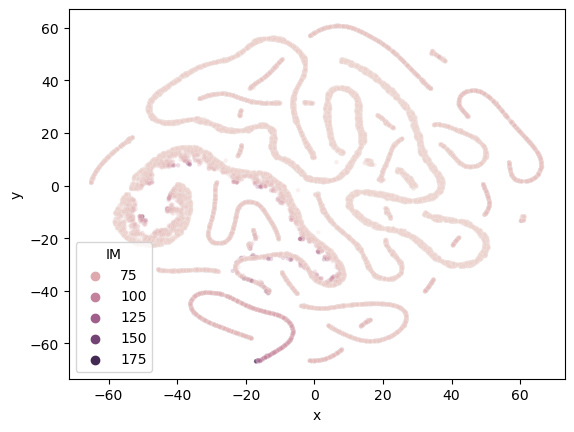

In [166]:
df_plt = pd.concat([xy_coor, df_sub.reset_index(drop=True)], axis=1)
sns.scatterplot(data=df_plt, x='x', y='y', s=10, hue='IM', alpha=0.25)

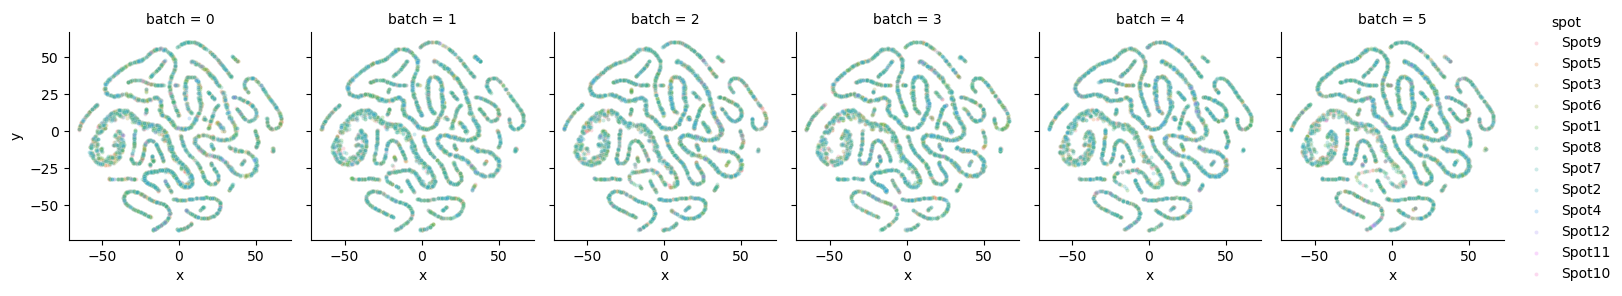

In [167]:
# fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.FacetGrid(df_plt, col="batch", aspect=0.85, hue='spot')
g.map(sns.scatterplot, "x", "y", s=8, alpha=0.25)
g.add_legend()

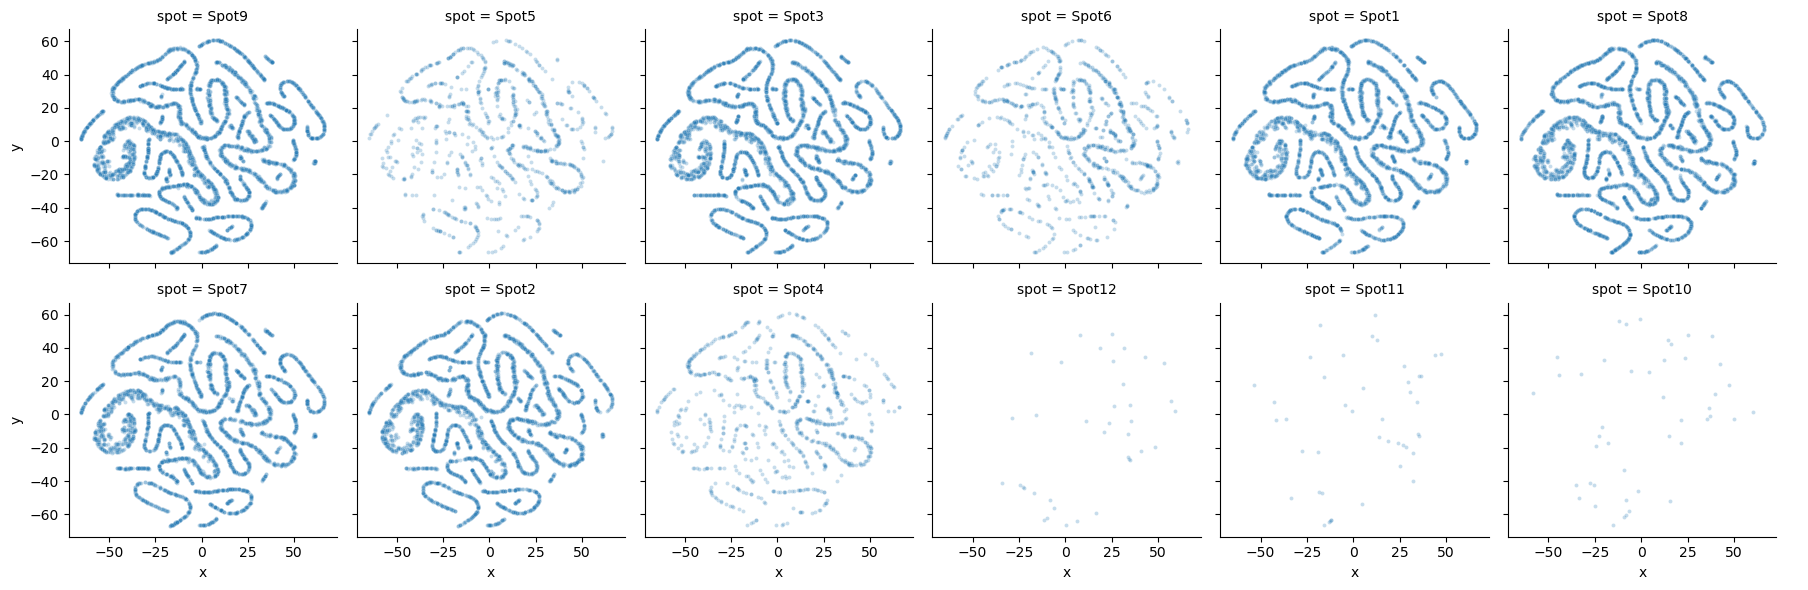

In [178]:
# fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.FacetGrid(df_plt, col="spot", aspect=1, col_wrap=6)
g.map(sns.scatterplot, "x", "y", s=8, alpha=0.25)
g.add_legend()

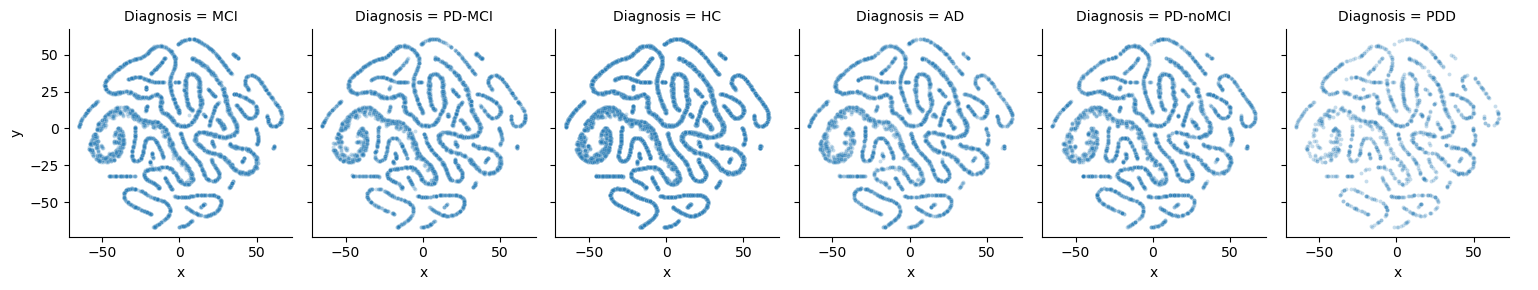

In [169]:
# fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.FacetGrid(df_plt, col="Diagnosis", aspect=0.85)
g.map(sns.scatterplot, "x", "y", s=8, alpha=0.25)
g.add_legend()

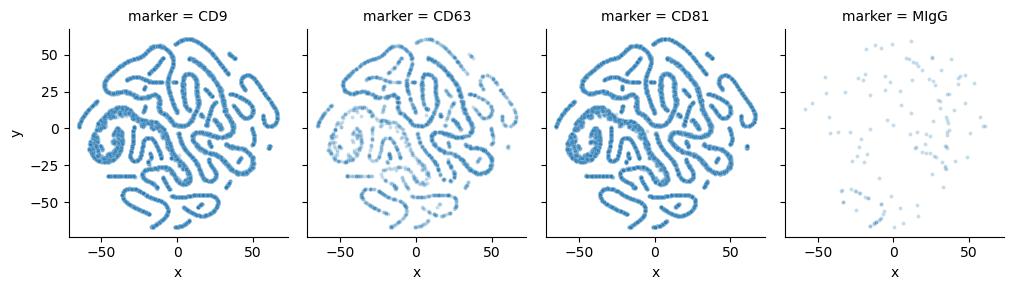

In [170]:
# fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.FacetGrid(df_plt, col="marker", aspect=0.85)
g.map(sns.scatterplot, "x", "y", s=8, alpha=0.25)
g.add_legend()

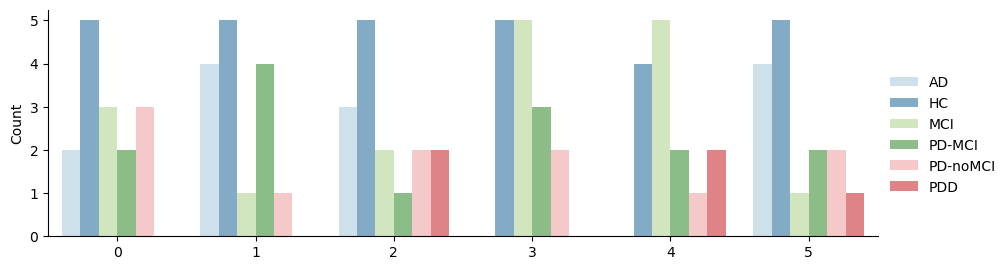

In [229]:
# classes in each batch
df_plt = df.drop_duplicates('samples').groupby(['batch', 'Diagnosis']).count().iloc[:, 0].reset_index()
g = sns.catplot(
    data=df_plt, kind="bar",
    x="batch", y="spot", hue="Diagnosis",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

In [244]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP']
df_plt = (df.groupby(['batch', 'samples'])[marker].apply(lambda x: (x>0).sum())/df.groupby(['batch', 'samples']).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(['batch', 'samples'])
df_plt.head(3)

,batch,samples,variable,value
0,0,14,A-Beta,0.580416
1,0,16,A-Beta,0.297991
2,0,20,A-Beta,0.719175


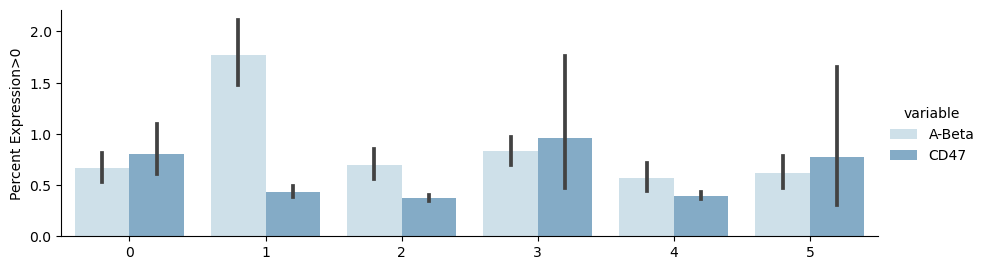

In [247]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], kind="bar",
    x="batch", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Percent Expression>0")
# g.legend.set_title("")

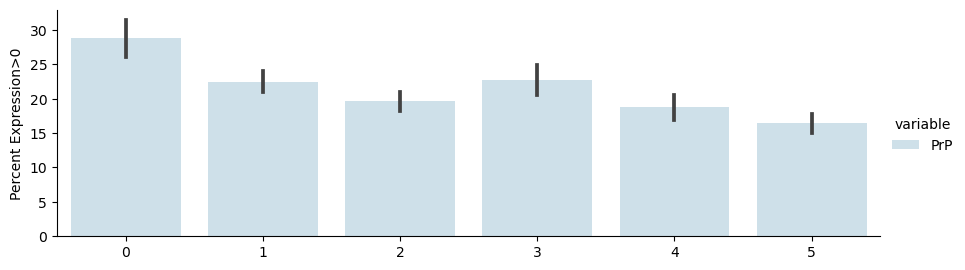

In [248]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], kind="bar",
    x="batch", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Percent Expression>0")
# g.legend.set_title("")

In [249]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP']
df_plt = (df.groupby(['Diagnosis', 'samples'])[marker].apply(lambda x: (x>0).sum())/df.groupby(['Diagnosis', 'samples']).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(['Diagnosis', 'samples'])
df_plt.head(3)

,Diagnosis,samples,variable,value
0,AD,31,A-Beta,0.510665
1,AD,32,A-Beta,0.404412
2,AD,33,A-Beta,1.196519


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD_CD47 vs. PD-MCI_CD47: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.641e-01 U_stat=6.300e+01
AD_A-Beta vs. PDD_A-Beta: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.000e+01


(<AxesSubplot:>,
  <statannotations.Annotation.Annotation at 0x7fdc68908c70>])

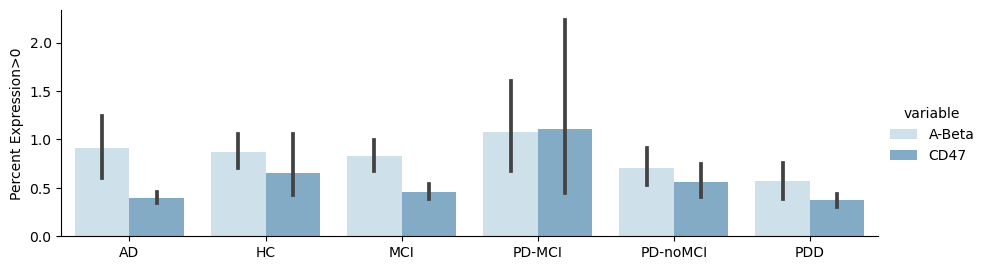

In [256]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], kind="bar",
    x="Diagnosis", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Percent Expression>0")
# g.legend.set_title("")

pairs = [[('AD', 'CD47'), ('PD-MCI', 'CD47')], [('AD', 'A-Beta'), ('PDD', 'A-Beta')]] #[[(i, "A-Bata"), (i, "A-Bata")] for i in df_plt.Diagnosis.unique()]
annotator = Annotator(ax, pairs, data=df_plt, x='Diagnosis', y='value', hue='variable')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
annotator.apply_and_annotate()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD_CD47 vs. PD-MCI_CD47: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.641e-01 U_stat=6.300e+01
AD_A-Beta vs. PDD_A-Beta: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.000e+01


(<AxesSubplot:>,
  <statannotations.Annotation.Annotation at 0x7fdc70bb78b0>])

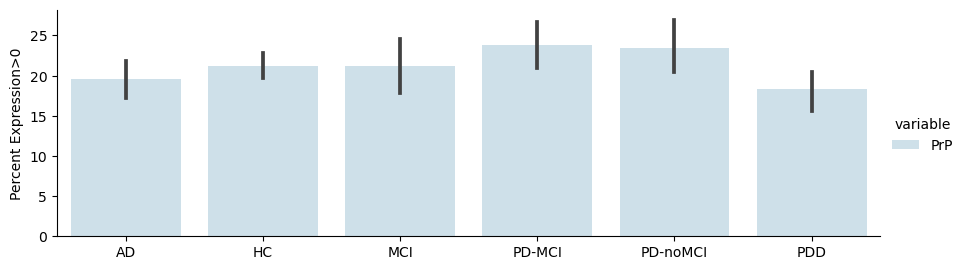

In [262]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], kind="bar",
    x="Diagnosis", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Percent Expression>0")
# g.legend.set_title("")

pairs = [[('AD', 'CD47'), ('PD-MCI', 'CD47')], [('AD', 'A-Beta'), ('PDD', 'A-Beta')]] #[[(i, "A-Bata"), (i, "A-Bata")] for i in df_plt.Diagnosis.unique()]
annotator = Annotator(ax, pairs, data=df_plt, x='Diagnosis', y='value', hue='variable')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
annotator.apply_and_annotate()

In [261]:
mannwhitneyu(df_plt.loc[(df_plt.Diagnosis=='AD') & (df_plt.variable=='CD47'), 'value'], df_plt.loc[(df_plt.Diagnosis=='PD-MCI') & (df_plt.variable=='CD47'), 'value'])

MannwhitneyuResult(statistic=63.0, pvalue=0.1820500814244328)

In [282]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP']
df_plt = (df.groupby(['Diagnosis', 'samples'])[marker].apply(lambda x: x[(x>0)].mean())).reset_index()
df_plt = df_plt.melt(['Diagnosis', 'samples'])
df_plt.head(3)

,Diagnosis,samples,variable,value
0,AD,31,A-Beta,675.906250
1,AD,32,A-Beta,654.272727
2,AD,33,A-Beta,663.757576


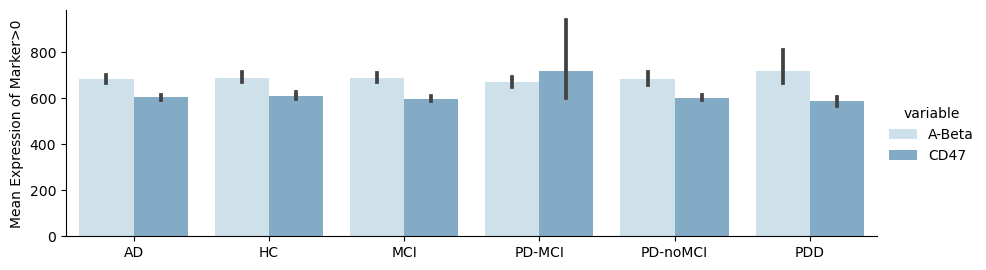

In [ ]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], kind="bar",
    x="Diagnosis", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Mean Expression of Marker>0")
# g.legend.set_title("")

# pairs = [[('AD', 'CD47'), ('PD-MCI', 'CD47')], [('AD', 'A-Beta'), ('PDD', 'A-Beta')]] #[[(i, "A-Bata"), (i, "A-Bata")] for i in df_plt.Diagnosis.unique()]
# annotator = Annotator(ax, pairs, data=df_plt, x='Diagnosis', y='value', hue='variable')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
# annotator.apply_and_annotate()

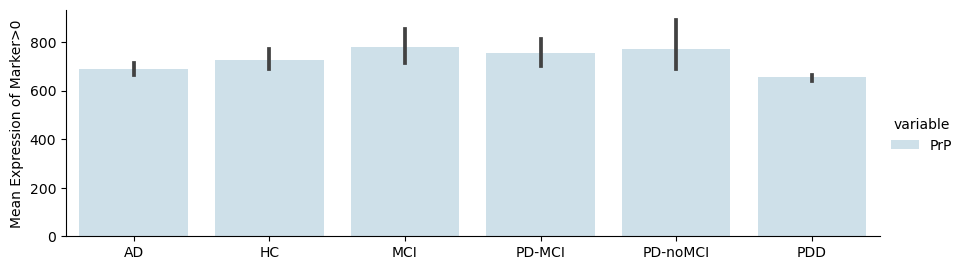

In [286]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], kind="bar",
    x="Diagnosis", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Mean Expression of Marker>0")
# g.legend.set_title("")

# pairs = [[('AD', 'CD47'), ('PD-MCI', 'CD47')], [('AD', 'A-Beta'), ('PDD', 'A-Beta')]] #[[(i, "A-Bata"), (i, "A-Bata")] for i in df_plt.Diagnosis.unique()]
# annotator = Annotator(ax, pairs, data=df_plt, x='Diagnosis', y='value', hue='variable')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
# annotator.apply_and_annotate()

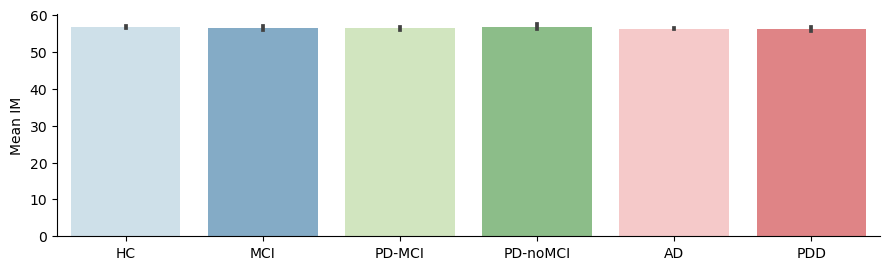

In [297]:
g = sns.catplot(
    data=pd.concat([df[['samples', 'Diagnosis']].drop_duplicates().set_index('samples'), df.groupby('samples').mean()], axis=1), 
    kind="bar",
    x="Diagnosis", y="IM",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Mean IM")
# g.legend.set_title("")

In [308]:
df

,spot,A-Beta,CD47,PrP,IM,marker,samples,batch,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
0,Spot4,0.0,0.0,0.0,53.497864,CD63,14,0,TPAD0470,141222,Kerchner,HC,14
1,Spot4,0.0,0.0,0.0,55.683592,CD63,14,0,TPAD0470,141222,Kerchner,HC,14
2,Spot4,0.0,0.0,0.0,54.707117,CD63,14,0,TPAD0470,141222,Kerchner,HC,14
3,Spot4,0.0,0.0,0.0,55.295506,CD63,14,0,TPAD0470,141222,Kerchner,HC,14
4,Spot4,0.0,0.0,0.0,94.367331,CD63,14,0,TPAD0470,141222,Kerchner,HC,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560055,Spot12,0.0,0.0,0.0,75.261573,MIgG,77,5,TPAD0446,141074,Poston,PD-MCI,77
1560056,Spot12,0.0,0.0,0.0,56.187997,MIgG,77,5,TPAD0446,141074,Poston,PD-MCI,77
1560057,Spot12,0.0,0.0,0.0,55.049512,MIgG,77,5,TPAD0446,141074,Poston,PD-MCI,77
1560058,Spot12,0.0,0.0,0.0,56.437910,MIgG,77,5,TPAD0446,141074,Poston,PD-MCI,77


In [309]:
# number of measurements by spots/batch/groups
df_plt = df.groupby(['batch', 'spot', 'Diagnosis', 'marker']).count().iloc[:, 0].reset_index()
df_plt

,batch,spot,Diagnosis,marker,A-Beta
0,0,Spot1,AD,CD81,3060
1,0,Spot1,HC,CD81,16427
2,0,Spot1,MCI,CD81,11681
3,0,Spot1,PD-MCI,CD81,7009
4,0,Spot1,PD-noMCI,CD81,8079
...,...,...,...,...,...
363,5,Spot9,HC,CD9,14778
364,5,Spot9,MCI,CD9,1617
365,5,Spot9,PD-MCI,CD9,4864
366,5,Spot9,PD-noMCI,CD9,7674


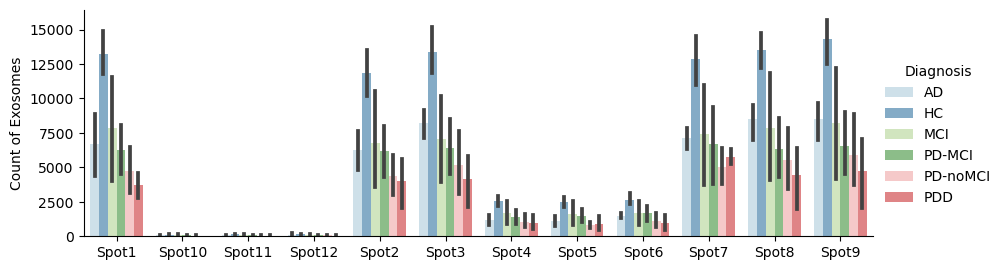

In [307]:
g = sns.catplot(
    data=df_plt, kind="bar",
    x="spot", y="A-Beta", hue="Diagnosis",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Count of Exosomes")
# g.legend.set_title("")

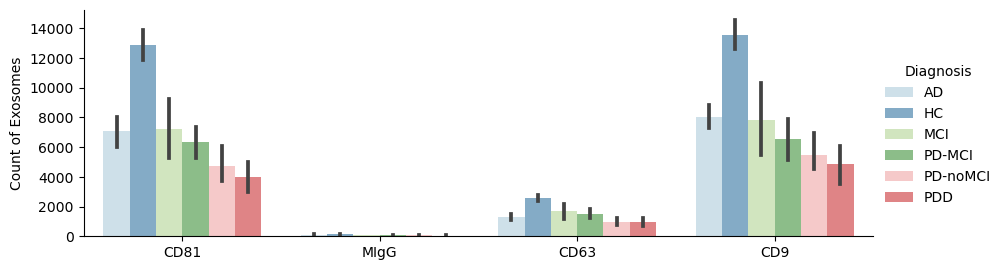

In [311]:
g = sns.catplot(
    data=df_plt, kind="bar",
    x="marker", y="A-Beta", hue="Diagnosis",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Count of Exosomes")
# g.legend.set_title("")